# Feature Store Deployment Quickstart

This notebook will deploy a Feast FeatureStore in your namespace to interact with for the demo.

## Log in

We need to use the privilege of your user in the deployment, instead of the Notebook server's own reduced privilege. From the OpenShift Web UI, click the user menu in the top right:

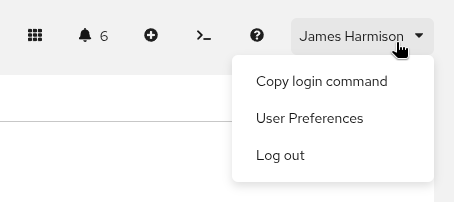

From here, select "*Copy login command*" and paste the contents after the comment in the following cell, keeping the exclamation mark at the beginning the line, before running it.
This will log you in to OpenShift as your own user.

In [ ]:
#!oc login --token=sha256~XXXXXXXXXXXXXXXXXXXX --server=https://api.cluster.example.com:6443
!

## Deploy PostgreSQL

Feast has roughly three main storage mechanisms we need to care about.

- The offline store, where historical feature data is stored when large accesses are needed (like training!)
- The online store, where important and recent data is made available with low latency (like for inference!)
- An internal registry, a sort of centralized metadata store that Feast uses to keep track of what has been done

We will be using a file-based duckdb database for the offline store, and a single replica non-production PostgreSQL instance for the online store and registry.
These options are highly configurable, and you should use solutions that meet your needs and environment's capabilities.

So, deploy that PostgreSQL instance:

In [ ]:
!oc apply -f postgres.yaml

## Confirming that OpenShift AI is managing the Feast Operator

OpenShift AI manages the installation of the Feast Operator for you.
Letting it do so means you're getting an operator built by Red Hat, versioned and lifecycled for enterprise use, and released ofen with new features.
To make sure it is already up and running in your environment, run the following:

In [ ]:
!oc get datasciencecluster default-dsc -ojsonpath='{.status.components.feastoperator.managementState}{"\n"}'
!oc get datasciencecluster default-dsc -ojsonpath='{.status.conditions[?(@.type=="FeastOperatorReady")].status}{"\n"}'

If you don't see the following:

```
Managed
True
```

Then you need to enable feastoperator in your DataScienceCluster. Uncomment and run the following cell to do that here if you have enough permission to do so:

In [ ]:
#!oc patch datasciencecluster default-dsc -p '{"spec": {"components": {"feastoperator": {"managementState": "Managed"}}}}' --type=merge

## Deploy Feast

It's time to use that operator and deploy a Feast instance:

In [ ]:
!oc apply -f feast.yaml
!oc rollout status deployment/feast-example

## Verify initialization

This may be paranoid, but I recommend making sure everything came up correctly.
If Feast connected to your PostgreSQL deployment, it should have initialized some tables.
We can check that, and also make sure that Feast is reporting the version we expect (0.58.0 in OpenShift AI 3.2):

In [ ]:
!oc exec deploy/postgres -- psql -h localhost -U feast feast -c '\dt'
!oc exec deployment/feast-example -itc online -- feast version

We also want to make sure that our configuration took place and that Feast is connecting to the right things:

In [ ]:
!oc exec deploy/feast-example -itc online -- cat feature_store.yaml

## Materialize Feast data

Feast has a concept called
[materialization](https://github.com/feast-dev/feast/blob/e2bad34e932aa992465f089cdf9af783978ad40a/docs/how-to-guides/running-feast-in-production.md#2-how-to-load-data-into-your-online-store-and-keep-it-up-to-date).
This process ensures that your online store is updated with the most accurate views into your offline data store.
OpenShift AI's Feast Operator runs materialization on a schedule, but we can trigger that schedule a bit early.
Confirm that the `CronJob` is configured first:

In [ ]:
!oc get feast/example -o jsonpath='{.status.applied.cronJob.containerConfigs.commands}'

You should see an array of commands, apply and materialize-incremental, like this:

```
["feast apply","feast materialize-incremental $(date -u +'%Y-%m-%dT%H:%M:%S')"]
```

If all looks well, we can start a one-off `Job` from that `CronJob`:

In [ ]:
!oc delete job feast-example-apply
!oc create job --from=cronjob/feast-example feast-example-apply
!oc wait --for=condition=complete --timeout=8m job/feast-example-apply
!oc logs job/feast-example-apply --all-containers=true

## Wrap-up

That's it! You've taken your first steps to understanding feature management in OpenShift AI. So far, we've:

- Deployed a non-production database (seriously, _do not_ let this database make it to production) for Feast
- Confirmed OpenShift AI is configured to help manage features, or made it that way
- Deployed Feast with some example data and configurations for loan processing features

Now that we have our data deployed, let's use Feast to get a better idea of what it enables.
You'll need to head back to the OpenShift AI UI to edit your workbench and associate the new Feature Store.

First, click the three-dots menu on the right of your Workbench, then select **Edit workbench**:

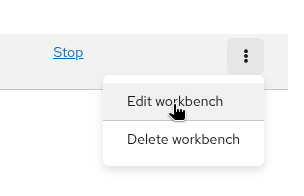

Scroll to the bottom, or use the navigation helpers on the left, to get to the **Feature stores** configuration. From the dropdown, select `credit_scoring_local`.

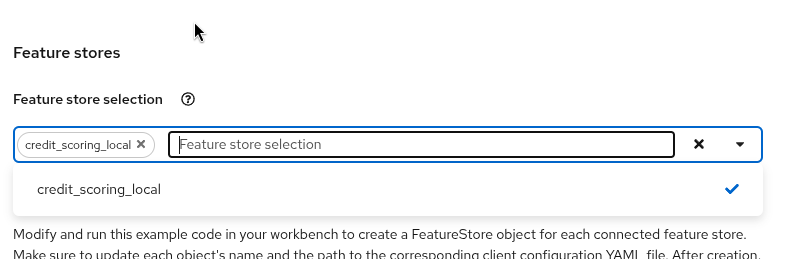

Heed the warning about your workbench restarting, and press the **Update workbench** button. When the pod finishes restarting you should be able to reload this page.

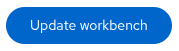